### Company XYZ sells software for $\$$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66\% of the users have seen the old price ($\$$39), while a random sample of 33\% users a higher price ($\$$59).

### The test has been running for some time, and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. Especially he asked you the following questions:

#### (1) Should the company sell its software for $\$$39 or $\$$59?

#### (2) The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

#### (3) [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

### Load the package would be used

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon

import gmaps
import gmaps.datasets
gmaps.configure(api_key = "AI.............................")

import statsmodels.stats.api as sms

### Read in the data set

In [2]:
user = pd.read_csv("../Datasets/Pricing_Test/user_table.csv")
test0 = pd.read_csv("../Datasets/Pricing_Test/test_results.csv")

### Look into data

In [3]:
print(user.shape)
print(test0.shape)

print(user.head)
print(test0.head)

print(user.info)
print(test0.info)

print(len(user["user_id"]) == len(pd.unique(user["user_id"])))
print(len(test0["user_id"]) == len(pd.unique(test0["user_id"])))

(275616, 5)
(316800, 8)
<bound method NDFrame.head of         user_id         city country    lat    long
0        510335      Peabody     USA  42.53  -70.97
1         89568         Reno     USA  39.54 -119.82
2        434134       Rialto     USA  34.11 -117.39
3        289769  Carson City     USA  39.15 -119.74
4        939586      Chicago     USA  41.84  -87.68
...         ...          ...     ...    ...     ...
275611   485975      Atlanta     USA  33.76  -84.42
275612    35479  Los Angeles     USA  34.11 -118.41
275613   516519      Chicago     USA  41.84  -87.68
275614   984877        Tampa     USA  27.96  -82.48
275615   232078  Springfield     USA  44.05 -122.98

[275616 rows x 5 columns]>
<bound method NDFrame.head of         user_id            timestamp           source  device operative_system  test  price  converted
0        604839  2015-05-08 03:38:34     ads_facebook  mobile              iOS     0     39          0
1        624057  2015-05-10 21:08:46       seo-google  mob

### Data cleaning and data processing

#### For the test table, we need to check if the price of all tested users is $\$$59 and that of all controlled users is $\$$39.

In [4]:
pd.crosstab(test0.price, test0.test, margins = False) 

test,0,1
price,,
39,202517,155
59,210,113918


#### Only retain valid records

In [5]:
test = test0[((test0["price"] == 39) & (test0["test"] == 0)) | ((test0["price"] == 59) & (test0["test"] == 1))]
test["revenue"] = test["price"] * test["converted"]
dat = test.merge(user, on = ["user_id"], how = "left")
list(dat.columns)

<ipython-input-5-684197fbd4aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["revenue"] = test["price"] * test["converted"]


['user_id',
 'timestamp',
 'source',
 'device',
 'operative_system',
 'test',
 'price',
 'converted',
 'revenue',
 'city',
 'country',
 'lat',
 'long']

#### (1) Should the company sell its software for $\$$39 or $\$$59?

Data Visualization: Before conducting A/B test, we prefer first examine if the randomization is valid.

#### Source

##### Conversion Rate

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

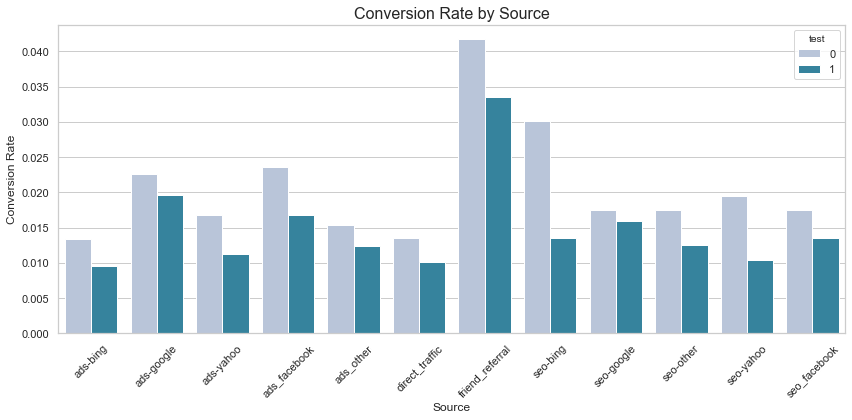

In [6]:
grp_source = dat[["test", "source", "converted"]].groupby(["test", "source"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "source", y = "converted", hue = "test", data = grp_source, palette = "PuBuGn")
plt.title("Conversion Rate by Source", fontsize = 16)
plt.xlabel("Source", fontsize = 12)
plt.ylabel("Conversion Rate", fontsize = 12)
plt.xticks(rotation = 45)

##### Revenue

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

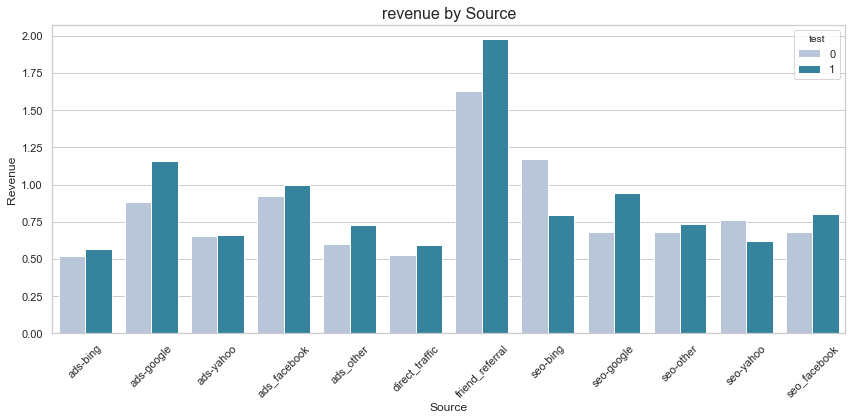

In [7]:
rev_source = dat[["test", "source", "revenue"]].groupby(["test", "source"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "source", y = "revenue", hue = "test", data = rev_source, palette = "PuBuGn")
plt.title("revenue by Source", fontsize = 16)
plt.xlabel("Source", fontsize = 12)
plt.ylabel("Revenue", fontsize = 12)
plt.xticks(rotation = 45)

#### Operating System

##### Conversion Rate

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

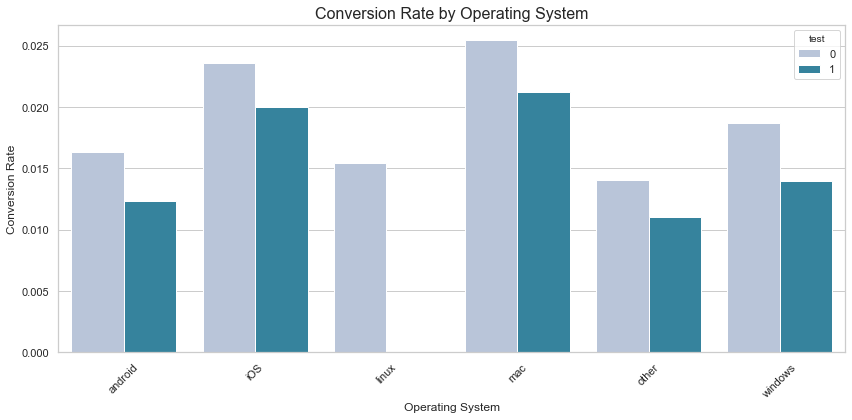

In [8]:
grp_os = dat[["test", "operative_system", "converted"]].groupby(["test", "operative_system"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "operative_system", y = "converted", hue = "test", data = grp_os, palette = "PuBuGn")
plt.title("Conversion Rate by Operating System", fontsize = 16)
plt.xlabel("Operating System", fontsize = 12)
plt.ylabel("Conversion Rate", fontsize = 12)
plt.xticks(rotation = 45)

##### Revenue

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

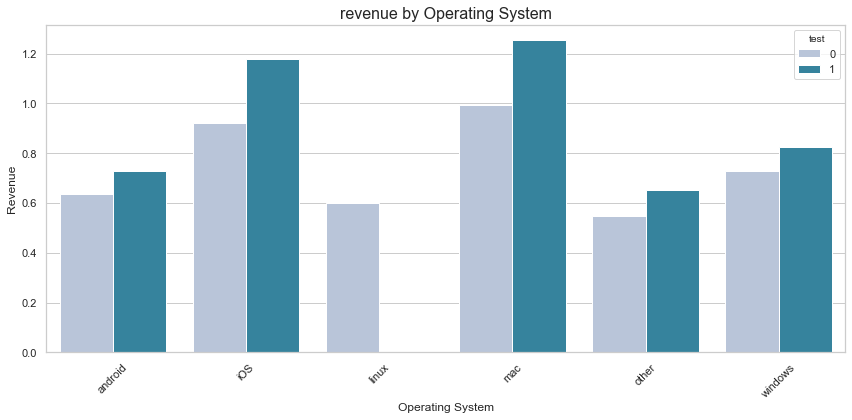

In [9]:
rev_os = dat[["test", "operative_system", "revenue"]].groupby(["test", "operative_system"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "operative_system", y = "revenue", hue = "test", data = rev_os, palette = "PuBuGn")
plt.title("revenue by Operating System", fontsize = 16)
plt.xlabel("Operating System", fontsize = 12)
plt.ylabel("Revenue", fontsize = 12)
plt.xticks(rotation = 45)

#### Device

##### Conversion Rate

(array([0, 1]), <a list of 2 Text xticklabel objects>)

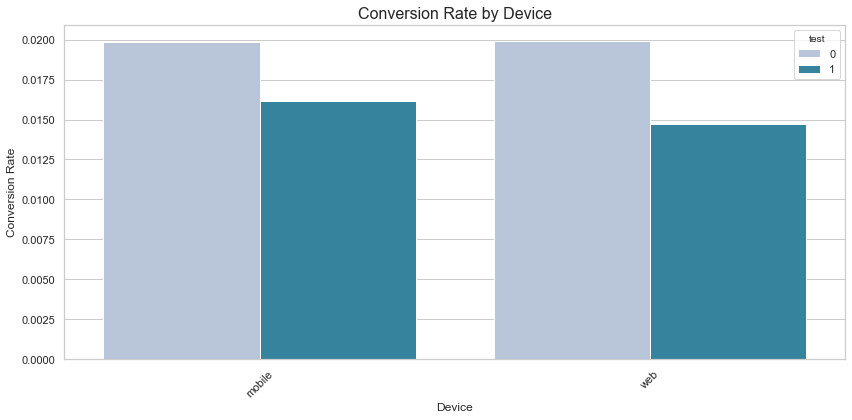

In [10]:
grp_device = dat[["test", "device", "converted"]].groupby(["test", "device"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "device", y = "converted", hue = "test", data = grp_device, palette = "PuBuGn")
plt.title("Conversion Rate by Device", fontsize = 16)
plt.xlabel("Device", fontsize = 12)
plt.ylabel("Conversion Rate", fontsize = 12)
plt.xticks(rotation = 45)

##### Revenue

(array([0, 1]), <a list of 2 Text xticklabel objects>)

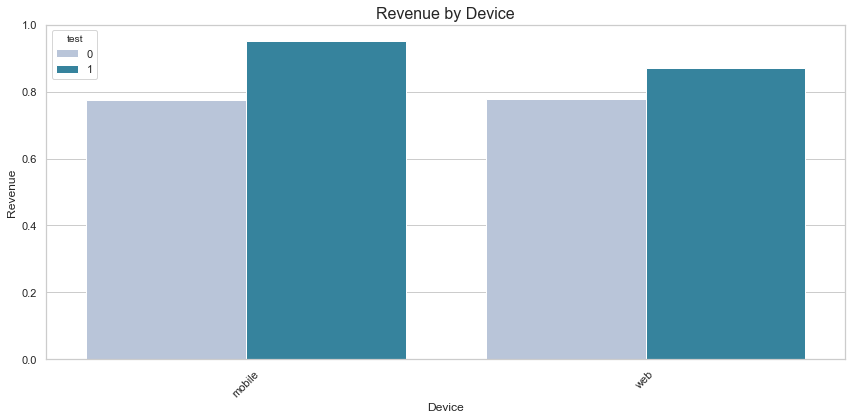

In [11]:
rev_device = dat[["test", "device", "revenue"]].groupby(["test", "device"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "device", y = "revenue", hue = "test", data = rev_device, palette = "PuBuGn")
plt.title("Revenue by Device", fontsize = 16)
plt.xlabel("Device", fontsize = 12)
plt.ylabel("Revenue", fontsize = 12)
plt.xticks(rotation = 45)

#### Location

##### Conversion Rate

In [12]:
dat_rmNA = dat[["lat", "long", "converted", "revenue"]].dropna()
locations = dat_rmNA[["lat", "long"]]
grp_weights = dat_rmNA["converted"]
rev_weights = dat_rmNA["revenue"]
figure_layout = {
    "width": "1200px",
    "height": "600px",
    "border": "1px solid black",
    "padding": "1px"
}
grp_fig = gmaps.figure(center = (37, -100), zoom_level = 8, layout = figure_layout)
grp_fig.add_layer(gmaps.heatmap_layer(locations, weights = grp_weights))
grp_fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px', width='1200px'))

In [13]:
grp_fig = gmaps.figure(center = (37, -100), zoom_level = 8, layout = figure_layout)
grp_fig.add_layer(gmaps.heatmap_layer(locations, weights = rev_weights))
grp_fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px', width='1200px'))

A/B test

In [14]:
dat_noLinux = dat[dat["operative_system"] != "linux"]

#### Overall/Country

##### Conversion Rate

In [15]:
country_converted = dat_noLinux.groupby(["country"])["converted"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(country_converted.sort_values(by = ["p_value"]))

         p_value  conversion_test  conversion_control
country                                              
USA            0         0.015716            0.019809


<ipython-input-15-8aa3fa6ee120>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  country_converted = dat_noLinux.groupby(["country"])["converted"].agg({


##### Revenue

In [16]:
country_revenue = dat_noLinux.groupby(["country"])["revenue"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(country_revenue.sort_values(by = ["p_value"]))

<ipython-input-16-1c6d6b81fc2e>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  country_revenue = dat_noLinux.groupby(["country"])["revenue"].agg({


         p_value  conversion_test  conversion_control
country                                              
USA            0         0.927254            0.772563


#### Source

##### Conversion Rate

In [17]:
converted_source = dat_noLinux.groupby(["source"])["converted"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(converted_source.sort_values(by = ["p_value"]))

<ipython-input-17-785b8bf8ef79>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  converted_source = dat_noLinux.groupby(["source"])["converted"].agg({


                      p_value  conversion_test  conversion_control
source                                                            
ads_facebook     1.430107e-07         0.017133            0.023736
direct_traffic   3.376515e-04         0.010276            0.013538
seo-yahoo        2.671745e-03         0.010643            0.019539
seo-bing         7.850955e-03         0.013631            0.030211
ads-bing         8.397473e-03         0.009691            0.013512
friend_referral  1.058047e-02         0.034535            0.041593
seo_facebook     2.993895e-02         0.013841            0.017667
ads-google       3.267788e-02         0.020020            0.022656
ads-yahoo        3.864071e-02         0.011339            0.017053
ads_other        5.216659e-02         0.012570            0.015305
seo-other        6.233042e-02         0.012700            0.017547
seo-google       4.770153e-01         0.016220            0.017484


##### Revenue

In [18]:
revenue_source = dat_noLinux.groupby(["source"])["revenue"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(revenue_source.sort_values(by = ["p_value"]))

<ipython-input-18-f514f49f0bba>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  revenue_source = dat_noLinux.groupby(["source"])["revenue"].agg({


                  p_value  conversion_test  conversion_control
source                                                        
ads-google       0.000004         1.181176            0.883590
seo-google       0.003250         0.956997            0.681873
friend_referral  0.003735         2.037538            1.622121
ads_other        0.047900         0.741604            0.596876
direct_traffic   0.094873         0.606298            0.527976
seo_facebook     0.159930         0.816636            0.688994
ads_facebook     0.185446         1.010860            0.925710
seo-bing         0.217067         0.804213            1.178248
seo-yahoo        0.363602         0.627916            0.762038
ads-bing         0.545854         0.571762            0.526954
seo-other        0.625350         0.749320            0.684328
ads-yahoo        0.977630         0.668983            0.665053


#### Operating System

##### Conversion Rate

In [19]:
os_converted = dat_noLinux.groupby(["operative_system"])["converted"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(os_converted.sort_values(by = ["p_value"]))

<ipython-input-19-d1eb96b34fd9>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  os_converted = dat_noLinux.groupby(["operative_system"])["converted"].agg({


                       p_value  conversion_test  conversion_control
operative_system                                                   
windows           7.354231e-09         0.014009            0.018704
android           7.947210e-06         0.012363            0.016336
iOS               2.320936e-04         0.019994            0.023595
mac               3.308660e-02         0.021240            0.025451
other             9.954733e-02         0.011060            0.014025


##### Revenue

In [20]:
os_revenue = dat_noLinux.groupby(["operative_system"])["revenue"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(os_revenue.sort_values(by = ["p_value"]))

<ipython-input-20-c9f8aaa26466>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  os_revenue = dat_noLinux.groupby(["operative_system"])["revenue"].agg({


                       p_value  conversion_test  conversion_control
operative_system                                                   
iOS               3.619264e-07         1.179648            0.920201
mac               1.146011e-02         1.253157            0.992597
windows           1.949366e-02         0.826534            0.729443
android           4.394503e-02         0.729405            0.637088
other             2.575224e-01         0.652563            0.546990


#### Device

##### Conversion Rate

In [21]:
device_converted = dat_noLinux.groupby(["device"])["converted"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(device_converted.sort_values(by = ["p_value"]))

<ipython-input-21-167e33aef669>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  device_converted = dat_noLinux.groupby(["device"])["converted"].agg({


        p_value  conversion_test  conversion_control
device                                              
mobile        0         0.016146            0.019872
web           0         0.015360            0.020064


##### Revenue

In [22]:
device_revenue = dat_noLinux.groupby(["device"])["revenue"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(device_revenue.sort_values(by = ["p_value"]))

<ipython-input-22-ff4b5ae1ccfe>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  device_revenue = dat_noLinux.groupby(["device"])["revenue"].agg({


             p_value  conversion_test  conversion_control
device                                                   
mobile  7.010981e-08         0.952624            0.775017
web     1.485049e-03         0.906235            0.782498


#### City

##### Conversion Rate

In [23]:
city_converted = dat_noLinux.groupby(["city"])["converted"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(city_converted.sort_values(by = ["p_value"]))

<ipython-input-23-0a08bf83c452>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  city_converted = dat_noLinux.groupby(["city"])["converted"].agg({
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                   p_value  conversion_test  conversion_control
city                                                           
Lincoln           0.000854              0.0            0.029333
Aurora            0.000857              0.0            0.027848
Port Saint Lucie  0.001429              0.0            0.046296
Joliet            0.001466              0.0            0.033784
Corpus Christi    0.004547              0.0            0.020253
...                    ...              ...                 ...
Whittier               NaN              0.0            0.000000
Wilson                 NaN              0.0            0.000000
Wyoming                NaN              0.0            0.000000
Yorba Linda            NaN              0.0            0.000000
Yuba City              NaN              0.0            0.000000

[923 rows x 3 columns]


##### Revenue

In [24]:
city_revenue = dat_noLinux.groupby(["city"])["revenue"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat_noLinux["test"] == 1], x[dat_noLinux["test"] == 0], equal_var = False).pvalue,
    "conversion_test": lambda x: x[dat_noLinux["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat_noLinux["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(city_revenue.sort_values(by = ["p_value"]))

<ipython-input-24-725bb4cb9ea8>:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  city_revenue = dat_noLinux.groupby(["city"])["revenue"].agg({


                   p_value  conversion_test  conversion_control
city                                                           
Lincoln           0.000854              0.0            1.144000
Aurora            0.000857              0.0            1.086076
Port Saint Lucie  0.001429              0.0            1.805556
Joliet            0.001466              0.0            1.317568
Corpus Christi    0.004547              0.0            0.789873
...                    ...              ...                 ...
Whittier               NaN              0.0            0.000000
Wilson                 NaN              0.0            0.000000
Wyoming                NaN              0.0            0.000000
Yorba Linda            NaN              0.0            0.000000
Yuba City              NaN              0.0            0.000000

[923 rows x 3 columns]


#### (2) The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

See my R solutions

#### (3) [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

Calculate sample size.